In [5]:
# ln -s ../code/analytic.py analytic.py
%matplotlib inline

import numpy as np
import pandas as pd

import nsfg

import thinkstats2
import thinkplot

from collections import Counter

## Survival curves

The **survival curve** $S(t)$ is a function that maps from a duration, $t$, to the probability of surviving longer than $t$. If one knows the distribution of durations, or "lifetimes", finding the survival curve is just the complement of the CDF. $$S(t)=1-CDF(t)$$ where $CDF(t)$ is the probability of a lifetime less than or equal to $t$.

In [6]:
preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

{'xscale': 'linear', 'yscale': 'linear'}

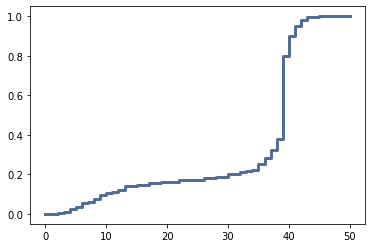

In [7]:
thinkplot.Cdf(cdf)

In [8]:
class SurvivalFunction(object):
    def __init__(self, ts, ss,label=''):
        self.ts = ts
        self.ss = ss
        self.label = label

    def __len__(self):
        return len(self.ts)

    def __getitem__(self,t):
        return self.Prob(t)

    def Prob(self, t):
        return np.interp(t, self.ts, self.ss, left=1.0)

    def Probs(self, ts):
        return np.interp(ts, self.ts, self.ss, left=1.0)

    def Items(self):
        return zip(self.ts, self.ss)

    def Render(self):
        return self.ts, self.ss

    def MakeHazardFunction(self, label=''):
        lams = pd.Series(index=self.ts)

        prev = 1.0
        for t,s in zip(self.ts, self.ss):
            lams[t] = (prev-s)/prev
            prev=s

        return HazardFunction(lams, label=label)

    def MakePmf(self, filler=None):
        cdf = thinkstats2.Cdf(self.ts, 1-self.ss)
        pmf = thinkstats2.Pmf()
        for val,prob in cdf.Items:
            pmf.Set(val,prob)

        cutoff = cdf.ps[-1]
        if filler is not None:
            pmf[filler] = 1-cutoff

        return pmf

    def RemainingLifetime(self, filler=None,
                          func=thinkstats2.Pmf.Mean):
        pmf = self.MakePmf(filler=filler)
        d={}
        for t in sorted(pmf.Values())[:-1]:
            pmf[t] = 0
            pmf.Normalize()
            d[t] = func(pmf) - t
        return pd.Series(d)


def MakeSurvivalFromSeq(values, label=''):
    counter = Counter(values)
    ts,freqs = zip(*sorted(counter.items()))
    ts = np.asarray(ts)
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    ss = 1-ps
    return SurvivalFunction(ts, ss, label)

def MakeSurvivalFromCdf(cdf, label=''):
    ts = cdf.xs
    ss = 1 - cdf.ps
    return SurvivalFunction(ts, ss, label)

class HazardFunction(object):
    def __init__(self, d, label=''):
        self.series = pd.Series(d)
        self.label = label
    
    def __len__(self):
        return len(self.series)

    def __getitem__(self,t):
        return self.series[t]

    def Get(self, t, default=np.nan):
        return self.series.get(t, default)

    def Render(self):
        return self.series.index, self.series.values

    def MakeSurvival(self, label=''):
        ts = self.series.index
        ss = (1-self.series).cumprod()
        sf = SurvivalFunction(ts,ss, label=label)
        return sf

    def Extend(self,other):
        last_index = self.series.index[-1] if len(self) else 0
        more = other.series(other.series.index > last_index)
        self.series = pd.concat([self.series, more])

    def Truncate(self,t):
        self.series = self.series[self.series.index < t]

def ConditionalSurvival(pmf, t0):
    cond = thinkstats2.Pmf()
    for t,p in pmf.Items():
        if t >= t0:
            cond.Set(t-t0,p)
    cond.Normalize()
    return MakeSurvivalFromCdf(cond.MakeCdf())

def PlotConditionalSurvival(durations):
    pmf = thinkstats2.Pmf(durations)

    times = [0,16,24,32]
    thinkplot.PrePlot(len(times))

    for t0 in times:
        sf = ConditionalSurvival(pmf,10)
        label=f't0={t0:d}'
        thinkplot.Plot(sf, label=label)
    thinkplot.Show()

def PlotSurvival(complete):
    thinkplot.PrePlot(3, rows=2)
    cdf = thinkstats2.Cdf(complete, label='cdf')
    sf = MakeSurvivalFromCdf(cdf, label='survival')
    print(cdf[13])
    print(sf[13])

    thinkplot.Plot(sf)
    thinkplot.Cdf(cdf, alpha=0.2)
    thinkplot.Config()

    thinkplot.SubPlot(2)
    hf = sf.MakeHazardFunction(label='hazard')
    print(hf[39])
    thinkplot.Plot(hf)
    thinkplot.Config(ylim = [0,0.75])


def PlotHazard(complete, ongoing):
    sf = MakeSurvivalFromSeq(complete)
    thinkplot.Plot(sf, label='old S(t)', alpha=0.1)

    thinkplot.PrePlot(2)

    hf = EstimateHazardFunction(complete, ongoing)
    thinkplot.Plot(hf, label='lams(t)', alpha=0.5)
    sf = hf.MakeSurvival()

    thinkplot.Plot(sf, label='S(t)')
    thinkplot.Show(xlable='t (weeks)')


def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    if np.sum(np.isnan(complete)):
        raise ValueError('complete contains NaNs')
    if np.sum(np.isnan(ongoing)):
        raise ValueError('ongoing contains NaNs')

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(f'{t:0.3g}\t{at_risk:d}\t{ended:d}\t{censored:d}\t{lams[t]:0.2g}')
        at_risk -= ended + censored

    return HazardFunction(lams, label=label)

def EstimateHazardNumpy(complete, ongoing, label=''):
    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = set(hist_complete) | set(hist_ongoing)
    at_risk = len(complete) + len(ongoing)

    ended = [hist_complete[t] for t in ts]
    ended_c = np.cumsum(ended)
    censored_c = np.cumsum([hist_ongoing[t] for t in ts])
    not_at_risk = np.roll(ended_c,1) + np.roll(censored_c,1)
    not_at_risk[0]=0

    at_risk_array = at_risk - not_at_risk
    hs = ended / at_risk_array

    lams = dict(zip(ts,hs))

    return HazardFunction(lams, label=label)


def AddLabelsByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = f'{name:d}0s'
        thinkplot.Plot([15],[1],label=label,**options)


def EstimateMarriageSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotPredictionsByDecade(groups, **options):
    hfs=[]
    for _,group in groups:
        hf,sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

def ResampleSurvival(resp, iters=101):
    _,sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _,sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5,95])
    thinkplot.FillBetween(ts, low, high,color='gray',label='90% CI')
    thinkplot.Show(xlabel='age (years)',
                   ylabel='prob unmarried',
                   xlim=[12,46],ylim=[0,1])

def EstimateMarriageSurvival(resp):
    complete = resp[resp.evrmarry==1].agemarry.dropna()
    ongoing = resp[resp.evrmarry==0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf,sf


def PlotMarriageData(resp):
    hf,sf = EstimateMarriageSurvival(resp)

    thinkplot.PrePlot(rows=2)
    thinkplot.Plot(hf)
    thinkplot.Config(ylabel='hazard', legend=False)

    thinkplot.SubPlot(2)
    thinkplot.Plot(sf)
    thinkplot.Show(xlabel='age (years)',
                   ylabel='prob unmarried',
                   ylim=[0,1], legend=False)
    return sf


def PlotPregnancyData(preg):
    complete = preg.query('outcome in [1,3,4]').prglngth
    print(f'# complete pregnancies: {len(complete)}')
    ongoing = preg[preg.outcome == '6'].prglngth
    print(f'# ongoing pregnancies: {len(ongoing)}')

    PlotSurvival(complete)
    thinkplot.Show(xlabel = 't (weeks)')

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    return sf


def PlotRemainingLifetime(sf1, sf2):
    thinkplot.PrePlot(cols=2)
    rem_life1 = sf1.RemainingLifetime()
    thinkplot.Plot(rem_life1)
    thinkplot.Config(title='remaining pregnancy length',
                     xlabel='weeks', ylabel='mean remaining weeks')

    thinkplot.SubPlot(2)
    func=lambda pmf: pmf.Percentile(50)
    rem_life2=sf2.RemainingLifetime(filler=np.inf, func=func)
    thinkplot.Plot(rem_life2)
    thinkplot.Config(title='years until first marriage',
                    xlim=[0,15], ylim=[11,31],
                    xlabel='age (years)', ylabel='median remaining years')

    thinkplot.Show()

def PlotResampleByDecade(resps, iters=11, predict_flag=False, omit=None):
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]
        if i==0:
            AddLabelsByDecade(groups, alpha=0.7)
        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)


def ReadFamResp1988():
    dat_file='./1995FemRespData.dat.gz'
    names=['cmintvm','timesmar','cmmarrhx','cmbirth','finalwgt']
    colspecs = [(12360-1, 12363),
                (4637-1, 4638),
                (11759-1, 11762),
                (14-1, 16),
                (12350-1, 12359)]
    df = pd.read(dat_file, compression='gzip',
                 colspecs=colspecs, names=names)
    df.timesmar.replace([98,99], np.nan, inplace=True)
    df['evmarry'] = (df.timesmar > 0)
    
    CleanFemResp(df)
    return(df)

def ReadFamResp2002():
    usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw', 
               'evrmarry', 'parity', 'finalwgt']
    df = ReadFemResp(usecols=usecols)
    df['evrmarry'] = (df.evrmarry == 1)
    CleanFemResp(df)
    return df

def ReadFemResp2010():
    usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw',
               'evrmarry', 'parity', 'wgtq1q16']
    df = ReadFemResp('2006_2010_FemRespSetup.dct',
                       '2006_2010_FemResp.dat.gz',
                        usecols=usecols)
    df['evrmarry'] = (df.evrmarry == 1)
    df['finalwgt'] = df.wgtq1q16
    CleanFemResp(df)
    return df    


def ReadFemResp2013():
    usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw',
               'evrmarry', 'parity', 'wgt2011_2013']
    df = ReadFemResp('2011_2013_FemRespSetup.dct',
                        '2011_2013_FemRespData.dat.gz',
                        usecols=usecols)
    df['evrmarry'] = (df.evrmarry == 1)
    df['finalwgt'] = df.wgt2011_2013
    CleanFemResp(df)
    return df


def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                **options):
    dct = thinkstats2.ReadStataDct(dct_file, encoding='iso-8859-1')
    df = dct.ReadFixedWidth(dat_file, compression='gzip', **options)
    return df


def CleanFemResp(resp):
    resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

    resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
    resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['year'] = (pd.DatetimeIndex(dates).year - 1900)
    resp['decade'] = resp.year // 10
    resp['fives'] = resp.year // 5



## Hazard function

Fraction of events that continue until $t$ and then end at $t+1$, $$\lambda(t)=\frac{S(t)-S(t+1)}{S(t)}$$

# complete pregnancies: 11189
# ongoing pregnancies: 0
0.1397801412101171
0.8602198587898829
0.6767068273092369


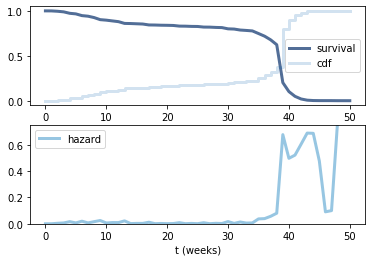

<Figure size 576x432 with 0 Axes>

In [10]:
preg = nsfg.ReadFemPreg()
sf1 = PlotPregnancyData(preg)

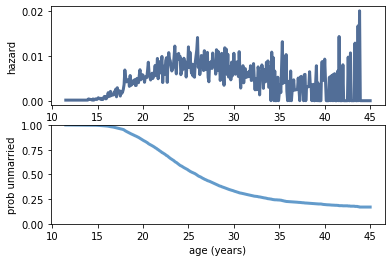

<Figure size 576x432 with 0 Axes>

In [11]:
resp6 = ReadFamResp2002()
sf2 = PlotMarriageData(resp6)

In [12]:
PlotRemainingLifetime(sf1,sf2)

TypeError: 'method' object is not iterable